# Time Series Workshop &minus; Exercise

ODSC East &minus; April 15, 2020

Mark Steadman
Viktor Kovryzhkin

https://github.com/vikua/time-series-workshop


## Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, RegressorMixin

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Re-run this cell to reset your recent score history
attempt_scores = {}

## Scoring Code (DO NOT EDIT)
This scoring code defines functions that will be called by the editable section after.

In [3]:
def fit_model(t, X, y, distance, apriori_columns=None, log_transform=False, 
              test_size=0.2, estimator=None, show=False, exercise=''):
    """Fits a forecasting model to predict a future value and displays its accuracy.
    
    Parameters
    ----------
    t : pandas.Series, shape = (n_samples, )
        The timestamps of each row in the data
    X : pandas.DataFrame, shape = (n_samples, n_features)
        The input features used for making predictions
    y : pandas.Series, shape = (n_samples, )
        The target values for each row
    distance : int
        The distance to forecast. Columns of X that are not listed in apriori_columns 
        will by shifted by this amount.
    apriori_columns : list[str]
        List of column names in X that should not be shifted by distance
    log_transform : bool
        Optional settings to enable log transform of the target
    test_size : float or int
        The percent or count of rows to use for the test set at the end of the time series
    estimator : sklearn.base.BaseEstimator
        Override the estimator used to fit the model
    show : bool
        Display a summary of the score, fit to the data, and feature impact

    Returns
    -------
    estimator : sklearn.base.BaseEstimator
        The fitted estimator model
    test_score : float
        The test split score (MASE by default)
    """
    # apply forecast distance to non a priori columns
    if apriori_columns is None:
        apriori_columns = []
    shift_cols = [c for c in X.columns if c not in apriori_columns]
    X[shift_cols] = X[shift_cols].shift(distance)
    
    # ignore missing value rows
    non_null = X.dropna(how='any').index.values

    # get row indices for train and test set
    if isinstance(test_size, float):
        test_size = int(test_size * len(t))
    train = non_null[:-test_size]
    test  = non_null[-test_size:]

    # standardize
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    centers = X.loc[train, numeric_cols].mean(axis=0)
    scales = np.maximum(1e-15, X.loc[train, numeric_cols].std(axis=0))
    X[numeric_cols] = (X[numeric_cols] - centers)/scales
    
    # fit model
    if estimator is None:
        estimator = ElasticNetCV(n_alphas=100, l1_ratio=0.9, cv=TimeSeriesSplit(5), 
                                 eps=0.00001, tol=0.00001, max_iter=10000, 
                                 selection='random', random_state=123)
    if log_transform:
        estimator = MultiplicativeEstimator(estimator)
    estimator.fit(X.loc[train, :], y[train])

    y_pred = estimator.predict(X.loc[test, :])
    naive = y.shift(distance).loc[test]
    test_score = mean_absolute_error(y[test], y_pred)/mean_absolute_error(y[test], naive)

    # track the recent scores
    if exercise not in attempt_scores:
        attempt_scores[exercise] = []
    attempt_scores[exercise].append(test_score)

    if show:
        display(HTML('<h4>rows: {}, columns: {}, distance: {}, test_size: {}, test_error: {}</h4>'.format(
            X.shape[0], X.shape[1], distance, test_size, test_score)))
        show_attempt_summary(exercise)

        # plot the fit
        display(HTML('<h3>Model Fit:</h3>'))
        plt.figure(figsize=(9,3))
        plt.plot(t, y, '.', c='gray', alpha=0.7)
        plt.plot(t[train], estimator.predict(X.loc[train, :]), 'b-', lw=2, alpha=0.7)
        plt.plot(t[test],  estimator.predict(X.loc[test, :]),  'r-', lw=2, alpha=0.7)
        plt.annotate('Test Error: {:%}'.format(test_score), 
                     xy=(0, 1), xytext=(12, -12), va='top', fontweight='bold',
                     xycoords='axes fraction', textcoords='offset points')
        plt.show()
        
        # show feature importances
        display(HTML('<h3>Important Features:</h3>'))
        if hasattr(estimator, 'coef_'):
            coef = pd.Series(estimator.coef_, index=X.columns, name='Importance')
            importances = coef.abs() / y.std()
            importances = importances[importances > 0]
            importances.loc['(others)'] = 0
            importances.sort_values(ascending=False, inplace=True)
            display(importances.to_frame().style.bar(color='orange'))
        else:
            display(HTML('<i>Not available</i>'))

    return estimator, test_score


def show_attempt_summary(ex):
    """Displays the recent scores"""
    if len(attempt_scores[ex]) > 1:
        score_delta = attempt_scores[ex][-1] - attempt_scores[ex][-2]
        if score_delta < 0:
            color = 'green'
        elif score_delta < 1e-6:
            color = 'gray'
        else:
            color = 'red'
        message = '<h3>Score Change: <span style="color:{};">{:+}</span></h3>'.format(color, score_delta)
        display(HTML(message))

        display(HTML('<h3>Recent Errors:</h3>'))
        plt.figure(figsize=(9,1))
        plt.title('Your Recent Errors')
        plt.plot(np.arange(len(attempt_scores[ex])), attempt_scores[ex], 'mo-', mec='white', ms=5)
        plt.axhline(min(attempt_scores[ex]), linestyle='--', alpha=0.5, color='gray')
        plt.axhline(attempt_scores[ex][-1], linestyle='-', alpha=0.5, color='gray')
        plt.xlim(0, len(attempt_scores[ex]))
        plt.ylim([0.95*min(attempt_scores[ex]), 1.05*np.nanpercentile(attempt_scores[ex], 95)])
        plt.show()


class MultiplicativeEstimator(BaseEstimator, RegressorMixin):
    """Wrapper class that applies a log transform to the target."""
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y, *args, **kwargs):
        self.estimator.fit(X, np.log(y), *args, **kwargs)
        return self
    
    def predict(self, X):
        return np.exp(self.estimator.predict(X))
    
    def __getattr__(self, name):
        return getattr(self.estimator, name)

---
## Exercise &minus; Electricity Usage

Maximize the test set accuracy for the dataset below. You are encouraged to create lagged feature, rolling window statistic feature, as well as a priori features. You create features by adding columns to the dataframe `X` below. For example:

```
X['y mean 10'] = y.rolling(10).mean()
X['y max 10']  = y.rolling(10).max()
...
```

You should edit the skeleton code in the next cell and run it in order to see your score. Be sure to use distinct names for each feature. You can create a name programatically using python string formatting such as `feature_name = '{} lag {}'.format('y', 1)`.

### Lags
You can create a lag of a variable using the `y.shift(n)` member. For example, `X['y lag 10'] = data['y'].shift(10)` would add the variable y lagged by 10 rows. 

### Rolling statistics
You can create statistics derived from a rolling window using the `y.rolling(n)` member. For example, `X['rolling mean 7'] = y.rolling(7).mean()` would add the rolling mean average of y over the past 7 rows.

For more details on other functions that can be called on the window (e.g. `min`, `max`, `sum`, etc), see the pandas documentation here:    
https://pandas.pydata.org/pandas-docs/stable/computation.html#window-functions


### A priori Features 
A priori features are features that are known in advance and are not lagged &minus; for example, features derived from the data like the day of the week. Be careful not to use any variables derived from the target or any other type of covariate. You can specify a feature a priori by appending it's name to the `apriori_columns` array:

```
X['day of week'] = t.dt.dayofweek
apriori_columns.append('day of week')
```

You can view other datetime properties supported by the `.dt` syntax above here:    
https://pandas.pydata.org/pandas-docs/stable/api.html#datetimelike-properties

### Scoring
You can score your features by calling `fit_model(..., show=True)`. The `show=True` parameter will print a summary of your recent model scores, show a plot of the fitted model to the data, and display a table of the feature importance for each feature that you created. If a feature does not appear it means it was not used by the model.



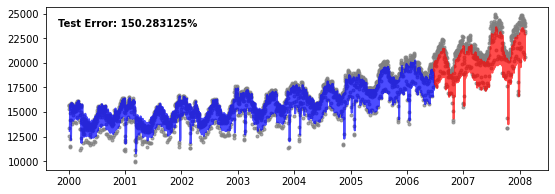

,Importance
lag 0,0.582011
is_month_start,0.079055
(others),0.000000


In [4]:
# SETUP: Read data and setup common variables (DO NOT EDIT)
data = pd.read_csv('data/turkish_electricity_demand.csv', parse_dates=['date'])
t = data['date']
X = pd.DataFrame()
y = data['y']
numeric_columns = data.select_dtypes(include=[np.number])
apriori_columns = []


# -----------------------------------------
# EDIT BELOW: Add Features to X
# -----------------------------------------

# EXAMPLE: Nearest lag
X['lag 0'] = y.shift(0)  

# EXAMPLE: first day of month indicator (a priori)
X['is_month_start'] = t.dt.is_month_start 
apriori_columns.append('is_month_start')


# SCORING: Fit model and and display fit and score (DO NOT EDIT)
model, score = fit_model(
    t, X, y, 
    apriori_columns=apriori_columns,
    log_transform=False,
    distance=7, 
    show=True,
    exercise='electricity',
)

---
## Another Dataset &minus; Stock Data
For fun, try to forecast the price of a stock into the future. Stock data is notoriously difficult to forecast. Expore this data to see if any signals exist and what accuracy is possible, if any. This data was collected via the Yahoo Finance API:

```
import pandas_datareader.data as web
data = web.DataReader(['IBM', 'GOOG', 'AAPL', 'MSFT'], 'yahoo', '2010-01-01', '2017-04-14')
data = data.sort_index()
data = data['Close']
data.to_csv('stock_close_prices.csv')
```


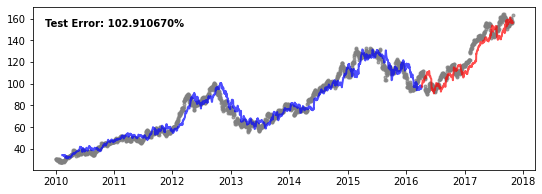

,Importance
lag 0,0.789545
(others),0.000000


In [5]:
# SETUP: Read data and setup common variables (DO NOT EDIT)
data = pd.read_csv('data/stock_close_prices.csv', parse_dates=['Date'])
t = data['Date']
X = pd.DataFrame()
y = data['AAPL']
numeric_columns = data.select_dtypes(include=[np.number])
apriori_columns = []

# -----------------------------------------
# EDIT BELOW: Add Features to X
# -----------------------------------------

# EXAMPLE: Nearest lag
X['lag 0'] = y.shift(0)  

# EXAMPLE: first day of month indicator (a priori)
X['is_month_start'] = t.dt.is_month_start 
apriori_columns.append('is_month_start')


# SCORING: Fit model and and display fit and score (DO NOT EDIT)
model, score = fit_model(
    t, X, y, 
    apriori_columns=apriori_columns,
    log_transform=False,
    distance=28, 
    show=True,
    exercise='stocks',
)

## Questions
1. What features tend to have the highest impact?
1. Do some features hurt the accuracy? Why?
1. What is the ideal number of lags?
1. What a priori features have the highest impact?
1. Is it better to use only the most recent data? How much?

## Further Exploration
1. Explore the impact of the forecast distance on accuracy
1. Explore the impact of log transforming the target
1. Explore the impact of differencing the target
1. Explore the impact of [other types of machine learning models](http://scikit-learn.org/stable/supervised_learning.html)
1. Compare results with a [classical ARIMA model](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)
1. Explore incorporating additional data (e.g. holidays, economic data, etc)
